In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio
import isolearn.keras as iso


Using TensorFlow backend.


In [2]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected2D, Conv1D, MaxPooling1D, LocallyConnected1D, LSTM, ConvLSTM2D, BatchNormalization
from keras.layers import Concatenate, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=False)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=False)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def load_residual_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_conv_0')
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='aparent_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_final_conv')
    
    extend_tensor = Lambda(lambda x: K.concatenate([x[0], x[1][..., None, None]], axis=2), name='aparent_extend_tensor')
    
    expand_lib = Lambda(lambda x: K.tile(K.expand_dims(K.expand_dims(x, axis=1), axis=2), (1, 1, 206, 1)), name='aparent_expand_lib')
    
    lib_conv = LocallyConnected2D(1, (1, 1), strides=(1, 1), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='aparent_lib_conv')
    
    lib_add = Lambda(lambda x: x[0] + x[1], name='aparent_lib_add')
    
    def _net_func(sequence_input, lib_input, dummy_input) :
        conv_0_out = conv_0(sequence_input)

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = extend_tensor([final_conv(skip_add_out), dummy_input])
        
        #Add library bias
        lib_conv_out = lib_add([final_conv_out, lib_conv(expand_lib(lib_input))])
        
        return lib_conv_out

    return _net_func

def get_kl_divergence() :
    
    def kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())

        return K.sum(y_true * K.log(y_true / y_pred), axis=-1)
    
    return kl_divergence

def get_sigmoid_kl_divergence() :
    
    def sigmoid_kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
        return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
    
    return sigmoid_kl_divergence

def load_aparent_model() :
    
    #APARENT parameters
    seq_input_shape = (1, 205, 4)
    lib_input_shape = (13,)
    num_outputs_iso = 1
    num_outputs_cut = 206
    
    #Plasmid model definition
    
    #Resnet function
    resnet = load_residual_network(
        n_groups=7,
        n_resblocks_per_group=4,
        n_channels=32,
        window_size=3,
        dilation_rates=[1, 2, 4, 8, 4, 2, 1],
        drop_rate=0.0
    )

    #Inputs
    seq_input = Input(shape=seq_input_shape)
    lib_input = Input(shape=lib_input_shape)
    dummy_input = Input(shape=(1,))
    plasmid_count = Input(shape=(1,))

    #Outputs
    true_iso = Input(shape=(num_outputs_iso,))
    true_cut = Input(shape=(num_outputs_cut,))

    cut_score = resnet(seq_input, lib_input, dummy_input)

    cut_prob = Lambda(lambda x: K.softmax(x[:, 0, :, 0], axis=-1))(cut_score)
    iso_prob = Lambda(lambda cl: K.expand_dims(K.sum(cl[:, 80:80+30], axis=-1), axis=-1))(cut_prob)

    plasmid_model = Model(
        inputs=[
            seq_input,
            lib_input,
            dummy_input
        ],
        outputs=[
            iso_prob,
            cut_prob
        ]
    )

    #Loss model definition
    sigmoid_kl_divergence = get_sigmoid_kl_divergence()
    kl_divergence = get_kl_divergence()
    
    plasmid_loss_iso = Lambda(sigmoid_kl_divergence, output_shape = (1,))([true_iso, iso_prob, plasmid_count])
    plasmid_loss_cut = Lambda(kl_divergence, output_shape = (1,))([true_cut, cut_prob, plasmid_count])

    total_loss = Lambda(
        lambda l: 0.5 * l[0] + 0.5 * l[1],
        output_shape = (1,)
    )(
        [
            plasmid_loss_iso,
            plasmid_loss_cut
        ]
    )

    loss_model = Model([
        seq_input,
        lib_input,
        dummy_input,
        plasmid_count,
        true_iso,
        true_cut
    ], total_loss)

    return [ ('plasmid_iso_cut_resnet', plasmid_model), ('loss', loss_model) ]


In [2]:
#Load sequence data

df = pd.read_csv('polyadb_processed_utr3.csv', sep='\t')
df = df.query("gene != 'na' and num_sites_pas_3 >= 2 and pas != -1 and pas <= 3 and site_type == '3_most_exon'").copy().reset_index(drop=True)
df = df.loc[~df['wide_seq_ext'].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAAA|AAAAGAAAA|AAAACAAAA|AAAAGAAAA|AAAACAAAA")].copy().reset_index(drop=True)

df_agg = df.groupby("gene").agg({"rpm" : "sum"}).copy().reset_index().rename(columns={"rpm" : "total_rpm"})
df = df.join(df_agg.set_index("gene"), on='gene', how='inner').copy().reset_index(drop=True)
df['usage'] = df['rpm'] / df['total_rpm']

df = df.query("usage > 0.0 and usage < 1.0").copy().reset_index(drop=True)

print("len(df) = " + str(len(df)))

n_samples = 20000

'''
sample_index = np.arange(len(df))
np.random.shuffle(sample_index)

df_sample = df.iloc[sample_index[:n_samples]].copy().reset_index(drop=True)
df_sample.to_csv('polyadb_processed_utr3_sample.csv', sep='\t', index=False)
'''
df_sample = pd.read_csv('polyadb_processed_utr3_sample.csv', sep='\t')

print("len(df_sample) = " + str(len(df_sample)))


len(df) = 69543
len(df_sample) = 20000


In [4]:
#Load APARENT Resnet

proximal_start = 77
proximal_end = 127

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = os.path.join(os.getcwd(), '')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_aparent_model()[0][1]
aparent_model.load_weights(model_path, by_name=True)

#Re-define model for total isoform attribution
seq_input = Input(name="seq_input", shape=(205, 4))
l_input = Input(name="l_input", shape=(13,))
dummy_input = Input(name="dummy_input", shape=(1,))

inflated_seq_input = Lambda(lambda x: x[:, None, ...], name='inflate_seq')(seq_input)

seq_cut = aparent_model([inflated_seq_input, l_input, dummy_input])[1]

def _lor(cuts_ref, iso_start=proximal_start, iso_end=proximal_end) :

    y_ref = K.sum(cuts_ref[:, iso_start:iso_end], axis=-1)[:, None]
    y_ref = K.clip(y_ref, K.epsilon(), 1.0 - K.epsilon())
    
    lor = K.log(y_ref / (1. - y_ref))

    return lor

lor_pred = Lambda(_lor, name='lor')(seq_cut)

predictor = Model(
    inputs=[seq_input, l_input, dummy_input],
    outputs=[lor_pred]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-04-23 17:39:48.056437: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-23 17:39:48.487382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 17:39:48.487799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P4 major: 6 minor: 1 memoryClockRate(GHz): 1.1135
pciBusID: 0000:00:04.0
2022-04-23 17:39:48.487830: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-04-23 17:39:48.490708: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-04-23 17:39:48.491979: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
202

In [5]:
#Predict isoform log odds for sequences

encoder = iso.OneHotEncoder(205)

x = np.concatenate([encoder.encode(row['wide_seq_ext'][175-70:175-70+205])[None, :, :] for _, row in df_sample.iterrows()], axis=0)

print("x.shape = " + str(x.shape))

l = np.zeros((x.shape[0], 13))
l[:, 11] = 1.

d = np.zeros((x.shape[0], 1))

y = predictor.predict(x=[x, l, d], batch_size=32, verbose=1)

print("y.shape = " + str(y.shape))


x.shape = (20000, 205, 4)



2022-04-23 17:39:55.326069: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8
2022-04-23 17:39:56.170682: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11


20000/20000 [==============================] - 16s 803us/step
y.shape = (20000, 1)


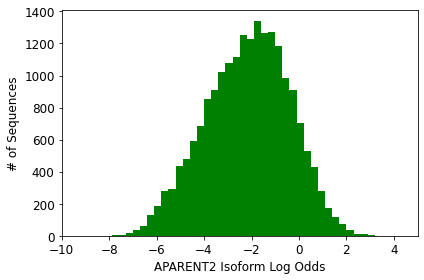

In [6]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(6, 4))

plt.hist(y[:, 0], color='green', bins=50, range=(-10., 5.))

plt.xlim(-10., 5.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT2 Isoform Log Odds", fontsize=12)
plt.ylabel("# of Sequences", fontsize=12)

plt.tight_layout()

plt.show()


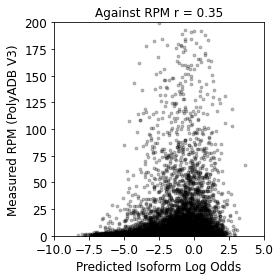

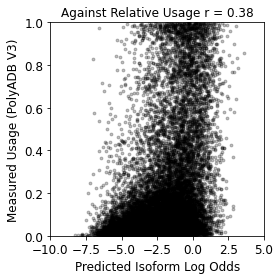

In [7]:
from scipy.stats import spearmanr

f = plt.figure(figsize=(4, 4))

plt.scatter(y[:,0], df_sample['rpm'], color='black', alpha=0.25, s=8)

plt.xlim(-10., 5.)
plt.ylim(0., 200.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Isoform Log Odds", fontsize=12)
plt.ylabel("Measured RPM (PolyADB V3)", fontsize=12)

r_val, _ = spearmanr(y[:,0], df_sample['rpm'])

plt.title("Against RPM r = " + str(round(r_val, 2)), fontsize=12)

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(y[:,0], df_sample['usage'], color='black', alpha=0.25, s=8)

plt.xlim(-10., 5.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Isoform Log Odds", fontsize=12)
plt.ylabel("Measured Usage (PolyADB V3)", fontsize=12)

r_val, _ = spearmanr(y[:,0], df_sample['usage'])

plt.title("Against Relative Usage r = " + str(round(r_val, 2)), fontsize=12)

plt.tight_layout()

plt.show()


In [41]:
#Cache predictions in dataframe

#df_sample["score"] = y[:, 0]

#df_sample.to_csv("polyadb_processed_utr3_sample_pred.csv", index=False, sep='\t')
df_sample = pd.read_csv('polyadb_processed_utr3_sample_pred.csv', sep='\t')


In [42]:
df_sample

,gene,gene_id,sitenum,num_sites,pas,seq,seq_ext,wide_seq,wide_seq_ext,pas_pos,...,sitenum_pas_3,sitenum_pas_2,sitenum_pas_1,num_sites_pas_4,num_sites_pas_3,num_sites_pas_2,num_sites_pas_1,total_rpm,usage,score
0,COX6C,COX6C.4,15,18,0,CGTCTTAAAGTGGAGAACACCTCTTTCAAACCAGTGGCTTTGGACG...,CTGAAATAAAAGCTCTGTTTGCCTAGCTCCCCAAACCTCTTCAGAT...,CATCTATTCAACATTAAACTCAGCACTGAAATAAAAGCTCTGTTTG...,TTAGCAGCCAGCCCAAGAAAAAAGGAGAAAAATCTTTCCTCCACAT...,100887152,...,10,9,8,15,13,12,11,334.626177,0.002841,-2.162444
1,GMFB,GMFB.13,4,16,2,ATACTTATTTATGCCTAAAAATGCACTGTTACTTACAGTTTGTTTC...,GTTTCTAAAGTATTTATGTATTAACCTGACCATACTGGAATCAGAC...,TTTTTTCACTAATGTGAACTTCTGTGTTTCTAAAGTATTTATGTAT...,TAAGAAATACCGAAGACCTAACTGAAGAATGGTTACGTGAGAAACT...,54944692,...,2,2,-1,14,13,7,3,30.282949,0.042803,-3.723169
2,PNN,PNN.26,26,26,0,TCCCCTGGTGCTCCAGAGTGAAATAGGGGTGAGTGGGGAATGGGCC...,CAGCCAGCACGTTAACTATAAGGAATGATCTTTTATTGTGGAATTC...,ACCTTTCCAAAAATTTGCTTTTTGACAGCCAGCACGTTAACTATAA...,ATTAAGACCTGCCATTTGTGATGTTCTGGACTCTACATCAAACAAT...,39656379,...,17,11,10,19,17,11,10,137.792753,0.006464,-1.077453
3,SLC35G2,SLC35G2.3,3,7,0,ACTGGAGGAATTTAAGAAAGCAGGACTACCAGGAAATACTAGACTC...,AGGGGTAATCATTATGATTAGTGTTTTTGTCCTTGCTGGCTATAAA...,TTCCTAGCATCTATGATGTTTTTGGAGGGGTAATCATTATGATTAG...,TTTGGAGATTGTGGTAGCTATGGTCTTGCAGCTTCTCGTGCTGCAC...,136574532,...,1,1,1,5,5,4,3,12.219149,0.346907,-3.563533
4,ZNF808,ZNF808.6,6,16,3,TTTTATAAATGTTACTGTGATTTTCTTGTAAGGAAGAATTAACTGT...,CCTTCTTTCACTGTTTTCAAGGTCAATAGCTGTGTGTTCACACTTC...,GCTTATGTCTCAGTTCTACAGTTGACCTTCTTTCACTGTTTTCAAG...,GCGTGAGCCATCGTGCCTGAAGACTCATGTATTCTTGATTGAAATA...,53060973,...,4,-1,-1,12,12,9,6,15.050152,0.067487,-4.583736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,FAM114A2,FAM114A2.2,10,11,0,TAGAGGTGTTCTGAATTTTAAACCTGAATTCTTCAGTTTAGAAAAC...,TAGTTGCTATTGATATCTCCATTTGAGAAATAGACATTTTTCTGTA...,TTTTGAGGGAGAGCTATTTTATAGGTAGTTGCTATTGATATCTCCA...,ACTGCTGAAAAAGGATGCTTTCTTTTGTACTTGTTTTTAGTGAAAG...,153369737,...,8,5,3,9,8,5,3,18.026899,0.105515,-1.284655
19996,GGPS1,GGPS1.13,13,21,3,GGGGTGGTGCAAGTGAATTCGTTTTCATTTAGAAGCCCCTCTGTAC...,CCACCTTTTAAAAAATTTGTTATTCTCCAGAAACAGTAAATAGGTG...,ATCTTTTTTTTGTCTTTTAGCCTTACCACCTTTTAAAAAATTTGTT...,TGAATAATGTTAAGCCATTCTTGATTGGACCTCATAGCTTATTTTA...,235506255,...,6,-1,-1,15,12,8,2,64.178979,0.011466,-3.416341
19997,ARHGAP27P1-BPTFP1-KPNA2P3,ARHGAP27P1-BPTFP1-KPNA2P3.2,8,9,2,TTCAGGATGGGGCTCCTGGGACCTTTAACTTTTAGATCATGTAGCT...,AGATCAAAACGTTGTGCCAGAAACTACCTCTGAAGGCTACACTTTC...,TTTTAATATATTTCCAGGAAGAGGAAGATCAAAACGTTGTGCCAGA...,AGACTTCAGGTAGGCTGCTGCTTGGAATACTTATTATTTTTATACT...,62746018,...,1,1,-1,2,2,2,1,2.872884,0.677929,-3.319700
19998,STAU2,STAU2.1,56,56,0,AAGCAAAACCACCACAAATCATGATCTGGCTGACTCACACGCGACT...,AACTGCTCGACCCAACATGACAATAGGAATATAATTATGTAAGATT...,GCAATGAGAAAACACTACATGGTCTAACTGCTCGACCCAACATGAC...,AACGTCATCGCATTGTTCAGGCTTTCTCCTTATTGATTTGCAAACA...,74332248,...,7,5,3,7,7,5,3,33.942428,0.042708,-1.735484


In [43]:

y = np.array(df_sample['score'].values)


In [18]:
#Initialize SHAP code

import tensorflow as tf

import shap
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    
    for l in [0]:
        projected_hypothetical_contribs = \
            np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        
        # At each position in the input sequence, we iterate over the
        # one-hot encoding possibilities (eg: for genomic sequence, 
        # this is ACGT i.e. 1000, 0100, 0010 and 0001) and compute the
        # hypothetical difference-from-reference in each case. We then 
        # multiply the hypothetical differences-from-reference with 
        # the multipliers to get the hypothetical contributions. For 
        # each of the one-hot encoding possibilities, the hypothetical
        # contributions are then summed across the ACGT axis to 
        # estimate the total hypothetical contribution of each 
        # position. This per-position hypothetical contribution is then
        # assigned ("projected") onto whichever base was present in the
        # hypothetical sequence. The reason this is a fast estimate of
        # what the importance scores *would* look like if different 
        # bases were present in the underlying sequence is that the
        # multipliers are computed once using the original sequence, 
        # and are not computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:, i] = 1.0
            hypothetical_difference_from_reference = \
                (hypothetical_input[None, :, :] - bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference * \
                                    mult[l]
            projected_hypothetical_contribs[:, :, i] = \
                np.sum(hypothetical_contribs, axis=-1) 
            
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))

    if len(orig_inp)>1:
        to_return.append(np.zeros_like(orig_inp[1]))
    if len(orig_inp)>2:
        to_return.append(np.zeros_like(orig_inp[2]))
    
    return to_return

def shuffle_several_times(s, numshuffles=20):
    return [
        np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
        np.array([s[1] for i in range(numshuffles)]),
        np.array([s[2] for i in range(numshuffles)])
    ]


In [ ]:
#Run SHAP (shared background samples from actual data)

n_bg_samples = 64

predictor_inp_bundle = [predictor.inputs[0], predictor.inputs[1], predictor.inputs[2]]
inp_bundle = [x, l, d]

backgrounds = [
    x[np.random.choice(np.arange(x.shape[0]), size=(n_bg_samples,), replace=False), ...],
    l[:n_bg_samples, ...],
    d[:n_bg_samples, ...]
]

predictor_explainer = shap.explainers.deep.TFDeepExplainer(
    (predictor_inp_bundle, tf.reduce_sum(predictor.outputs[0], axis=-1)),
    backgrounds, 
    combine_mult_and_diffref=combine_mult_and_diffref)

print("--- Generating SHAP scores ---")

s = predictor_explainer.shap_values(inp_bundle, progress_message=100)[0]
s_gated = s * x

print("s.shape = " + str(s.shape))
print("s_gated.shape = " + str(s_gated.shape))


In [44]:
#Store SHAP scores

import pickle

shap_dict = {
    'onehot': x,
    'shap': s,
    'shap_gated': s_gated,
    'backgrounds' : backgrounds,
}

pickle.dump(shap_dict, open("polyadb_processed_utr3_sample_shap.pickle", 'wb'))


In [24]:
#Code to visualize selected PWMs

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#from .. import util

def ic_scale(pwm,background):
    per_position_ic = util.compute_per_position_ic(
                       ppm=pwm, background=background, pseudocount=0.001)
    return pwm*(per_position_ic[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_weights_given_ax(ax=ax, array=array,**kwargs)
    plt.show()


def plot_score_track_given_ax(arr, ax, threshold=None, **kwargs):
    ax.plot(np.arange(len(arr)), arr, **kwargs)
    if (threshold is not None):
        ax.plot([0, len(arr)-1], [threshold, threshold])
    ax.set_xlim(0,len(arr)-1)


def plot_score_track(arr, threshold=None, figsize=(20,2), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_score_track_given_ax(arr, threshold=threshold, ax=ax, **kwargs) 
    plt.show()


In [4]:
#Re-load SHAP scores (bgs sampled from actual data)

import pickle

shap_dict = pickle.load(open("polyadb_processed_utr3_sample_shap.pickle", 'rb'))
x = shap_dict['onehot']
s = shap_dict['shap']
s_gated = shap_dict['shap_gated']


In [ ]:
import modisco

##########################
# run tfmodisco workflow #
##########################
tfm_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                  sliding_window_size=8,
                  flank_size=5,
                  target_seqlet_fdr=0.05,
                  max_seqlets_per_metacluster=40000, # don't put constrain on this
                  seqlets_to_patterns_factory=
                      modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                          n_cores=16, # use 16 cores
                          trim_to_window_size=8,
                          initial_flank_to_add=3,
                          kmer_len=5, num_gaps=1,
                          num_mismatches=0,
                          final_min_cluster_size=20
                      )
                  )(
                task_names=["task"], #list(target_importance.keys()),
                contrib_scores={"task": x * s}, #target_importance,
                hypothetical_contribs={"task": s}, #target_hypothetical,
                revcomp=False,
                one_hot=x)


In [6]:
import h5py

h5_out = h5py.File('polyadb_processed_utr3_sample_tfmodisco.h5', 'w')
tfm_results.save_hdf5(h5_out)
h5_out.close()


In [57]:
#Visualize motifs (actual example background)

import h5py

modisco_f = h5py.File('polyadb_processed_utr3_sample_tfmodisco.h5', 'r')

fwd_pwms = []
fwd_contribs = []
fwd_hypo_contribs = []
fwd_activations = []

patterns = modisco_f['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']

for i in range(len(patterns) - 1) :
    fwd_pwms.append(patterns["pattern_" + str(i)]["sequence"]["fwd"][()])
    fwd_contribs.append(patterns["pattern_" + str(i)]["task_contrib_scores"]["fwd"][()])
    fwd_hypo_contribs.append(patterns["pattern_" + str(i)]["task_hypothetical_contribs"]["fwd"][()])
    
    matches = modisco_f['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_" + str(i)]["seqlets_and_alnmts"]["seqlets"][()]
    
    acts = np.zeros((x.shape[0], x.shape[1]))
    
    for match_ix in range(matches.shape[0]) :
        match_str = str(matches[match_ix])
        
        example_ix = int(match_str.split("example:")[1].split(",start")[0])
        begin_ix = int(match_str.split("start:")[1].split(",end")[0])
        
        acts[example_ix, begin_ix] = 1.
    
    fwd_activations.append(acts)

pwms = []
ents = []
contribs = []
hypo_contribs = []
acts = []

included_index = [
    0, 1, 3, 4, 5, 7, 13, 17, 19, 21, 22, 25, 27
]

start_index = [
    5, 4, 3, 7, 6, 4, 3, 5, 3, 4, 0, 3, 3
]

pwm_names = [
    "CSE", "Trich1", "TGTA", "Trich2", "CstF1", "CstF2", "HNRNPH21", "Trich3", "SuperCSE1", "HNRNPH22", "CstF5", "WeaKCSE", "HNRNPH23"
]

#included_index = np.arange(len(patterns)-1).tolist()
#pwm_names = ["pwm_" + str(i) for i in range(len(patterns)-1)]

for i, start_ix in zip(included_index, start_index) :
    pwms.append(fwd_pwms[i])
    ents.append((2. - np.sum(fwd_pwms[i] * -np.log2(fwd_pwms[i] + 1e-7), axis=-1))[:, None] * fwd_pwms[i])
    contribs.append(fwd_contribs[i])
    hypo_contribs.append(fwd_hypo_contribs[i])
    
    acts.append(np.concatenate([np.zeros((x.shape[0], start_ix)), fwd_activations[i]], axis=-1)[:, :x.shape[1]])


CSE


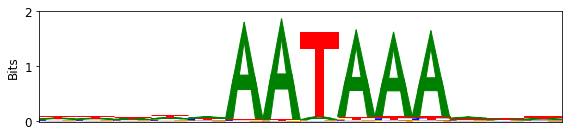

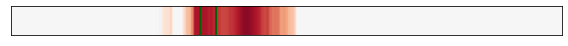

----------
Trich1


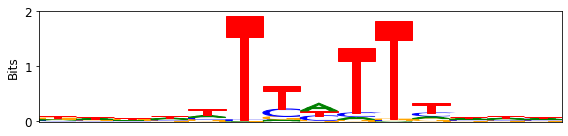

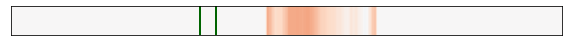

----------
TGTA


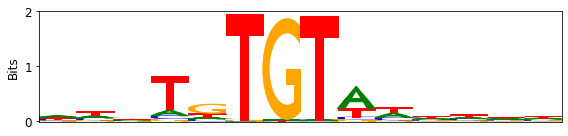

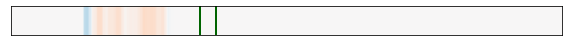

----------
Trich2


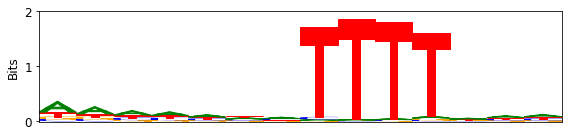

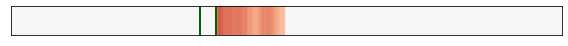

----------
CstF1


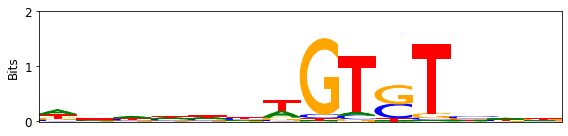

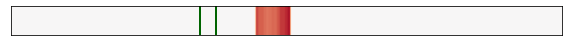

----------
CstF2


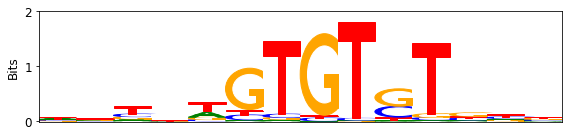

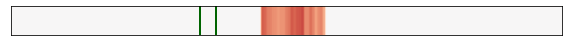

----------
HNRNPH21


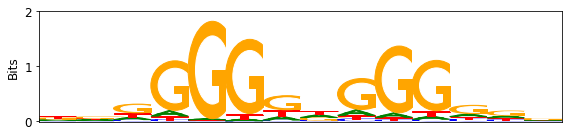

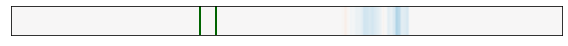

----------
Trich3


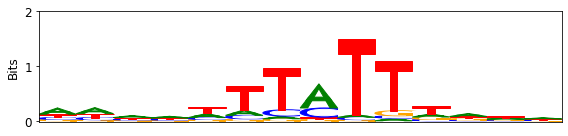

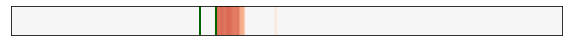

----------
SuperCSE1


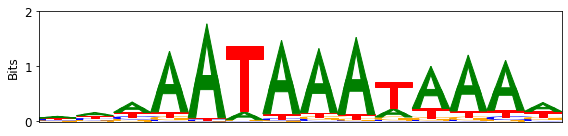

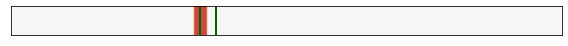

----------
HNRNPH22


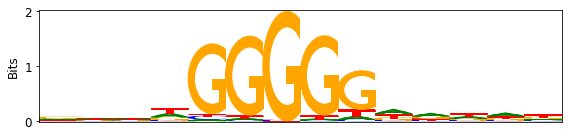

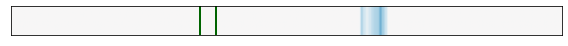

----------
CstF5


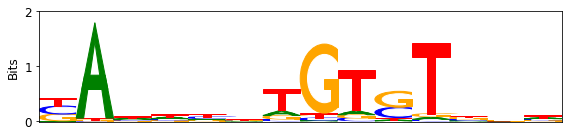

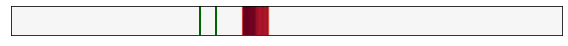

----------
WeaKCSE


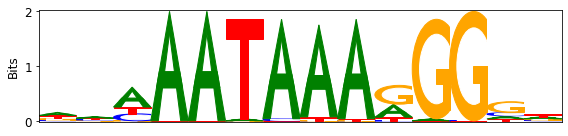

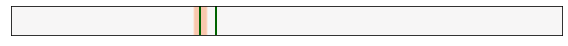

----------
HNRNPH23


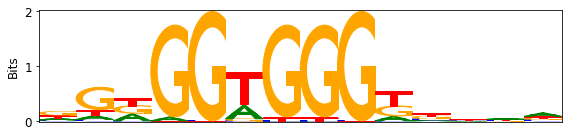

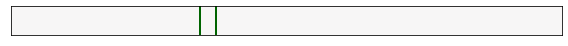

----------


In [114]:
#Plot and store sequence logos

def plot_pwm(weights, pwm_name, save_prefix, figsize=(8, 2)) :
    colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
    
    plot_funcs = {0: plot_a, 1: plot_c, 
                  2: plot_g, 3: plot_t}

    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_subplot(111) 
    
    plot_weights_given_ax(ax=ax, array=weights, 
                                       height_padding_factor=0.01,
                                       length_padding=0., 
                                       subticks_frequency=1.0, 
                                       colors=colors, plot_funcs=plot_funcs, 
                                       highlight={}, ylabel="")

    plt.sca(ax)
    plt.xticks([], [])
    plt.yticks([0, 1, 2], [0, 1, 2], fontsize=12)
    
    plt.ylabel("Bits", fontsize=12)
    #plt.title(pwm_name, fontsize=12)
    
    plt.tight_layout()
    
    if save_prefix is not None :
        plt.savefig(save_prefix + pwm_name + ".png", dpi=300, transparent=True)
        plt.savefig(save_prefix + pwm_name + ".eps")
    
    plt.show()

def plot_act(act, y, pwm_name, save_prefix, min_act_count=25., window_size=5, figsize=(8, 0.75)) :
    
    fig = plt.figure(figsize=figsize)
    
    act_corrs = np.zeros(x.shape[1])

    for j in range(x.shape[1]) :
        if np.sum(act[:, max(j-window_size//2, 0):min(j+window_size//2+1, x.shape[1])]) >= min_act_count :
            act_corrs[j] = np.mean(y[np.sum(act[:, max(j-window_size//2, 0):min(j+window_size//2+1, x.shape[1])], axis=-1) >= 1.]) - np.mean(y[np.sum(act[:, max(j-window_size//2, 0):min(j+window_size//2+1, x.shape[1])], axis=-1) <= 0.])
        else :
            act_corrs[j] = 0.

    act_corrs[np.isnan(act_corrs)] = 0.
    
    plt.imshow(act_corrs[None, :], aspect='auto', cmap="RdBu_r", vmin=-2., vmax=2.)

    plt.axvline(x=70, color='darkgreen', linewidth=2, linestyle='-')
    plt.axvline(x=76, color='darkgreen', linewidth=2, linestyle='-')
    
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.tight_layout()
    
    if save_prefix is not None :
        plt.savefig(save_prefix + pwm_name + "_act.png", dpi=300, transparent=True)
        plt.savefig(save_prefix + pwm_name + "_act.eps")

    plt.show()

save_prefix = "polyadb_processed_utr3_sample_modisco_short_"

for i in range(len(pwms)) :
    
    print(pwm_names[i])
    
    #Plot PWM
    plot_pwm(ents[i], pwm_names[i], save_prefix)
    
    #Plot activation LORs
    plot_act(acts[i], y, pwm_names[i], save_prefix)

    print("----------")
